In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import importlib
import xarray as xr
import scipy.spatial as spatial

In [2]:
import beam_utils
importlib.reload(beam_utils)
import tri_mesh
importlib.reload(tri_mesh)

<module 'tri_mesh' from '/home/leeaspitarte/code/MHD-Photoionization/modeling/cfd/tri_mesh.py'>

# Beam Integration using using xarray datasets

This demonstrate beam integration using an xarray dataset for the beam data.


## Create Interpolating Function from  Simulation Data

In [8]:
# viz_path = r"C:\Users\Huckaby\Desktop\MHD\Simulations\viz_example" 
#print(os.listdir(viz_path))
# fname = "frontCyl_plasma.vtk"
# fname = "frontCyl.vtk"
# fname = os.path.join(viz_path, fname)

from mhdpy.fileio import gen_path
from mhdpy.analysis.standard_import import *
sp_dir = gen_path('sharepoint')
results_dir = pjoin(sp_dir, 'Team Member Files', 'DaveH', 'Results', 'axiJP8200_17Jul23')
case = "mdot0130_phi080_K010"
fname = os.path.join(results_dir, "medium",case,"frontCyl.vtk")

f_axi = beam_utils.new_soln_interpolator(fname, do_plot=False)

## Construct Beam Dataset

### Beam Mesh

In [9]:
x_exit = 207.910 * 1e-3
x_min = 0.25
x_center = x_min
offset = np.array([-0.05,0.0,-0.1])

pos_center = np.array([x_center,0,0])
pos_source = pos_center + offset
pos_target = pos_center - offset

beam_axis = -offset
jet_axis = (1,0,0)
shat = beam_utils.coordinate_tensor(beam_axis, jet_axis)
L_beam = beam_utils.mag(offset)*2.0

x_beam = np.linspace(0,L_beam)
d_beam = 1e-2
# creates pos[:,:], mesh:pv.mesh, ds:xr.dataset, 
tri_out = tri_mesh.new_cylinder(x=x_beam,r=d_beam/2.0,n_theta=60)


In [ ]:
tri_out.keys()

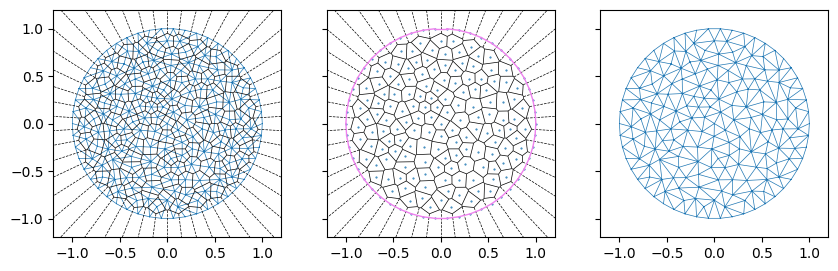

In [ ]:
fig, ax = plt.subplots(1,3,sharex=True,sharey=True)
for a in ax:
    a.set_aspect(1.0)
circle = tri_mesh.new_disk(n_theta=50, angle=30.0, do_plot=False)
v = circle["vertices"]
vor = spatial.Voronoi(v)
hull = spatial.ConvexHull(v,qhull_options='QG-100')
for i in [0,1]:
    spatial.voronoi_plot_2d(vor, ax=ax[i], line_width=0.5, point_size=1.0, show_vertices=False, show_points=i)

for visible_facet in hull.simplices[hull.good]:
    ax[1].plot(hull.points[visible_facet, 0],
            hull.points[visible_facet, 1],
            color='violet',
            lw=1)

for i in [0,2]:
    ax[i].triplot(v[:,0], v[:,1], circle["triangles"], linewidth=0.5)
fig.set_size_inches(10,10)

#### **Figure** Mesh and Voronoi Cross-section

Left - Voronoi and Mesh
Center - Voronoi w/ Mesh vertices and Convex Hull (purple)
Right - Mesh edges

Since the beam is being integration along the vertices, there are two options to reconstruct the 

1. "Trapazoidal Rule"
    I_face = \sum_i A_i I_i
    I_i = \sum_k I_{j = vertex[i,k]}/n_vertex
    i - triangles
    j - verticies
    v[k] - vertrex k of triangle i

1a. Invert the summation
    I_face = \sum_j Ahat_j I_j
    Ahat_j = \sum_k \sum_i (A_i/3) delta_{j,vertex[i,k]}
      
2. "Voronoi Cell"
     I_face = \sum_i Ahat_j I_j
     Ahat_j <- area of the Voronio cell for the interior
     for exterior cells, the area inside the boundary.

1a is probably the best approach, since Ahat_j can be calcualted once a resused for all wavelengths   

In [11]:
def transform_beam(ds, shat):
    ds["pos_beam"] = ds["pos"]*1.0
    ds["pos"][:] = np.matmul(ds["pos_beam"].to_numpy(),shat) + pos_source

### Create Dataset

Add concentration and temperature to the dataset

In [12]:
ds = tri_out["ds"]
transform_beam(ds, shat)

In [13]:
f_out = f_axi(ds["pos"])
ds["T"] = ("s","ray"), f_out[:,:,0].T
ds["K"] = ("s","ray"), f_out[:,:,1].T

In [14]:
ds

<xarray.Dataset>
Dimensions:      (s: 50, ray: 264, i_dir: 3)
Coordinates:
  * s            (s) float64 0.0 0.004563 0.009127 ... 0.2145 0.219 0.2236
  * ray          (ray) int64 0 1 2 3 4 5 6 7 ... 256 257 258 259 260 261 262 263
  * i_dir        (i_dir) <U1 'x' 'y' 'z'
    x            (s, ray) float64 0.2 0.2045 0.2044 ... 0.2967 0.2987 0.2982
    y            (s, ray) float64 0.0 0.0 0.0005226 ... -0.003911 -0.00176
    z            (s, ray) float64 -0.1 -0.1022 -0.1022 ... 0.1017 0.1007 0.1009
Data variables:
    pos          (s, ray, i_dir) float64 0.2 0.0 -0.1 ... 0.2982 -0.00176 0.1009
    v_area       (ray) float64 3.842e-07 1.7e-07 ... 3.859e-07 3.394e-07
    v_weights    (ray) float64 0.004892 0.002164 0.002338 ... 0.004913 0.004322
    v_triangles  (ray) int64 7 3 3 2 3 3 2 3 2 3 3 3 ... 5 5 5 6 7 6 7 7 7 7 7 6
    pos_beam     (s, ray, i_dir) float64 0.0 0.0 0.0 ... -0.002065 -0.00176
    T            (s, ray) float64 300.0 300.0 300.0 300.0 ... 300.0 300.0 300.0
    K            (s, ray) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [15]:
ds.coords["x"] = ("s", "ray"), ds["pos"].data[:,:,0]
ds.coords["y"] = ("s", "ray"), ds["pos"].data[:,:,1]
ds.coords["z"] = ("s", "ray"), ds["pos"].data[:,:,2]
ds

<xarray.Dataset>
Dimensions:      (s: 50, ray: 264, i_dir: 3)
Coordinates:
  * s            (s) float64 0.0 0.004563 0.009127 ... 0.2145 0.219 0.2236
  * ray          (ray) int64 0 1 2 3 4 5 6 7 ... 256 257 258 259 260 261 262 263
  * i_dir        (i_dir) <U1 'x' 'y' 'z'
    x            (s, ray) float64 0.2 0.2045 0.2044 ... 0.2967 0.2987 0.2982
    y            (s, ray) float64 0.0 0.0 0.0005226 ... -0.003911 -0.00176
    z            (s, ray) float64 -0.1 -0.1022 -0.1022 ... 0.1017 0.1007 0.1009
Data variables:
    pos          (s, ray, i_dir) float64 0.2 0.0 -0.1 ... 0.2982 -0.00176 0.1009
    v_area       (ray) float64 3.842e-07 1.7e-07 ... 3.859e-07 3.394e-07
    v_weights    (ray) float64 0.004892 0.002164 0.002338 ... 0.004913 0.004322
    v_triangles  (ray) int64 7 3 3 2 3 3 2 3 2 3 3 3 ... 5 5 5 6 7 6 7 7 7 7 7 6
    pos_beam     (s, ray, i_dir) float64 0.0 0.0 0.0 ... -0.002065 -0.00176
    T            (s, ray) float64 300.0 300.0 300.0 300.0 ... 300.0 300.0 300.0
    K            (s, ray) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

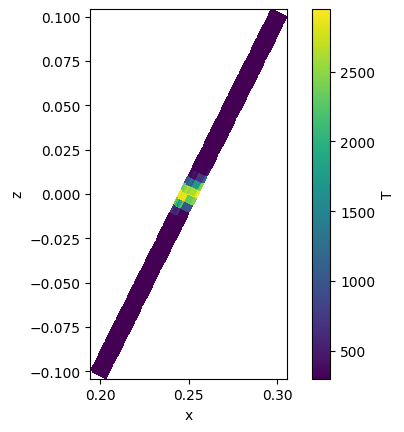

In [16]:
fig, ax = plt.subplots()
ax.set_aspect(1.0)
ds["T"].plot(x="x",y="z", ax=ax)

In [17]:
### **Figure** Temperature Contour On Beam

## Adaptive Refinement of Beam Mesh

In [18]:
ds_diff = ds.diff("s")

In [19]:
v_min = ds.min(dim="s")
v_max = ds.max(dim="s")
w_small = 1e-6
wv_small = 1e-12
weights = (v_max - v_min) + (v_max + v_min)*w_small + wv_small
adapt_vars = "T","K"
rtol = 1e-2

In [20]:
max_iter = 10
ds_new = ds.copy()
for i in range(max_iter):
    ds_diff = ds.diff("s")
    mask = (ds_diff > rtol*weights).any("ray")
    i_new = np.concatenate([ np.where(mask[v].to_numpy())[0] for v in adapt_vars ])
    i_new = np.unique(i_new)
    
    s_new = (ds.s[i_new] + ds.s[i_new+1])*0.5
    #coords = ds.coords.copy()
    coords = {"s": s_new}
    #ds_new = ds.DataSet(coords)

    break

In [21]:
ds_new = beam_utils.adapt_beam(ds, f_axi, do_plot=False)
#raise Exception

pos_beam


Text(0, 0.5, 'T [K]')

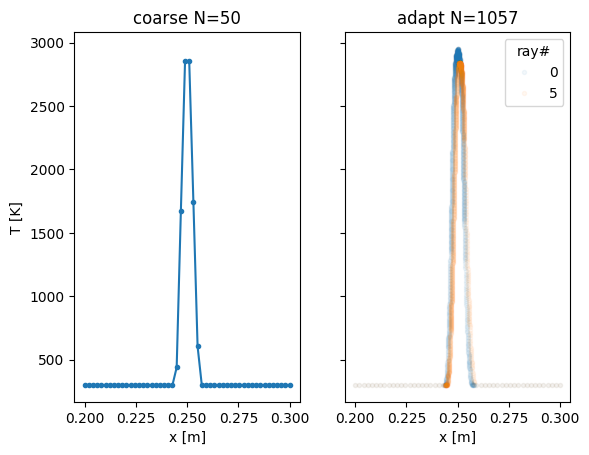

In [22]:
fig, ax = plt.subplots(1,2,sharex=True, sharey=True)
out = ax[0].plot(ds["x"].sel(ray=0),ds["T"].sel(ray=0),'.-')
ax[0].set_title("coarse N={}".format(len(ds["x"])))
out = ax[1].plot(ds_new["x"].sel(ray=0),ds_new["T"].sel(ray=0),'.',alpha=0.05, label=0)
out = ax[1].plot(ds_new["x"].sel(ray=0),ds_new["T"].sel(ray=5),'.',alpha=0.05, label=5)
ax[1].legend(title="ray#")
ax[1].set_title("adapt N={}".format(len(ds_new["x"])))
ax[1].set_xlabel("x [m]")
ax[0].set_xlabel("x [m]")
ax[0].set_ylabel("T [K]")

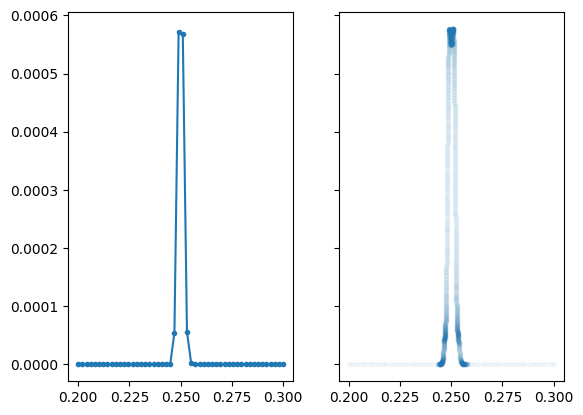

In [23]:
fig, ax = plt.subplots(1,2,sharex=True, sharey=True)
out = ax[0].plot(ds["x"].sel(ray=0),ds["K"].sel(ray=0),'.-')
out = ax[1].plot(ds_new["x"].sel(ray=0),ds_new["K"].sel(ray=0),'.',alpha=0.05, label=0)

### **Figure** Temperature Profile of the first ray in the beam

x - is the coordinate parallel to jet axis

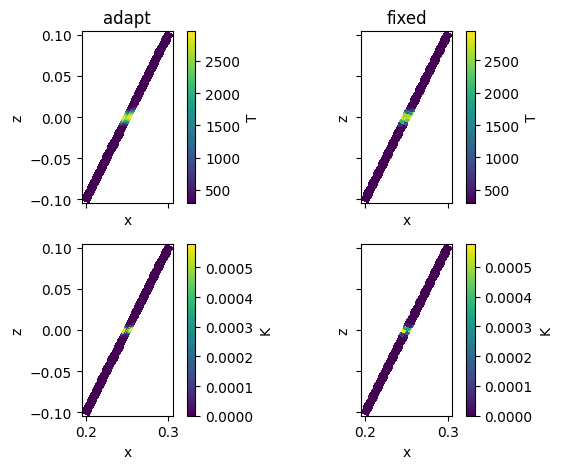

In [24]:
fig, ax = plt.subplots(2,2,sharex=True,sharey=True)
for a in ax.flat:
    a.set_aspect(1.0)
ds_new["T"].plot(x="x",y="z",ax=ax[0,0])
ds["T"].plot(x="x",y="z",ax=ax[0,1])
ds_new["K"].plot(x="x",y="z",ax=ax[1,0])
ds["K"].plot(x="x",y="z",ax=ax[1,1])
ax[0,0].set_title("adapt")
ax[0,1].set_title("fixed")
fig.tight_layout()

### **Figure** Comparison on Bean Temperature and Potassium contours

## Beam Integration

### Experimental Source 

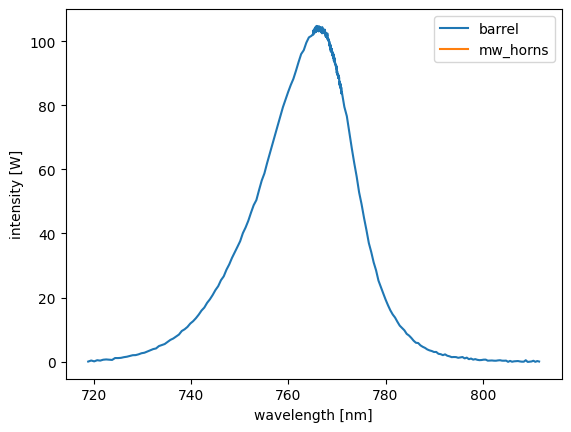

In [26]:
# data_path = r"C:\Users\Huckaby\Desktop\MHD\Simulations\viz_example"
data_path = '/home/leeaspitarte/code/MHD-Photoionization/experiment/data/proc_data'
fname = "ds_calib.cdf"
fname = os.path.join(data_path,fname)
source_fine = beam_utils.read_intensity_wavelength_function(fname, do_plot=False)

waves = source_fine.wavelength
n_fine = len(waves)
print("n_waves source",n_fine)
n_waves = 50
n_skip = int(n_fine/n_waves)
ii = np.concatenate( [ np.arange(0,n_fine,n_skip), [-1]] )
print(ii)

source = source_fine.isel(wavelength=ii)

u = source["diff"].isel(time=0).drop("time")
for mp in u.mp.data:
    v = u.sel(mp=mp)
    plt.plot(v["wavelength"], v, label=mp)
plt.xlabel("wavelength [nm]")
plt.ylabel("intensity [W]")
plt.legend()

#### **Figure** - Source Intensity

### Arbitrary Gaussian Absoprtion Cross Section

In [29]:
import cross_section
importlib.reload(cross_section)
Q_absorption = cross_section.GaussAbsorption(b=[-0.3,-0.3])
# normalization factor
Q_absorption.Q0 = 1e-23

AttributeError: module 'cross_section' has no attribute 'GaussAbsorption'

In [28]:
import beam_utils
import scipy.constants as constants
kB = constants.Boltzmann
importlib.reload(beam_utils)
p_ref = 1e5
ds_new["n_mix"] = p_ref/(ds_new["T"]*kB)
ds_new["n_K"] = ds_new["K"]*ds_new["n_mix"]
beam_utils.calc_absorption(source, ds_new, Q_absorption)

NameError: name 'Q_absorption' is not defined

In [ ]:
wave_nm = ds_new.wavelength

def plot_cross(Q_func, T_list=[1000]):
    fig, ax = plt.subplots(2,1,sharex=True)
    for T in T_list:
        Q = Q_func(T, wave_nm)   
        ax[0].semilogy(wave_nm, Q)
        ax[1].plot(wave_nm, Q, label=T)
    ax[1].set_xlabel("wavelength [nm]")
    ax[0].set_ylabel("cross section [m^2]")
    ax[1].set_ylabel("cross section [m^2]")
    ax[1].legend(title="T")

def f_Q(T, wave_nm):
    return np.array([Q_absorption(T, w) for w in wave_nm.to_numpy()])  

plot_cross(f_Q, [300,500,1500])

In [ ]:
#ds_new["I_target"].isel(wavelength=20,ray=0).plot()

#### **Figure** - Gaussian Cross Section vs. Wavelength


In [ ]:
tau = ds_new["I_target"].isel(mp=0,ray=0)/ds_new["I_source"].isel(mp=0)
tau.plot()

In [ ]:
#### **Figure** - Transmissivity vs. Wavelength for first ray

In [ ]:
n_wave = len(ds_new.wavelength)
tau = ds_new["I_target"].isel(mp=0,wavelength=int(n_wave/3.0))/ds_new["I_source"].isel(mp=0,wavelength=int(n_wave/3.0))
plt.plot(tau, ds_new["y"].isel(s=-1), 'o')
plt.xlabel(r"$\tau$")
plt.ylabel("y [m]")

### **Figure** - Transmissivity as function of vertical position

In [ ]:
import matplotlib.tri as plt_tri
def target_plot(ds):
    n_wave = len(ds.wavelength)
    f = ds["I_target"].isel(wavelength=int(n_wave/3.0), mp=0)
    f_rel = (f - f.min())/(f.max() - f.min())
    #print(z.max(), z.min())
    cmap = plt.get_cmap("viridis")
    color=cmap(f_rel)
    fig, ax = plt.subplots(1,2,sharex=True,sharey=True)
    x, z, y = ds["x"].isel(s=-1)**2, ds["z"].isel(s=-1)**2 + ds["x"].isel(s=-1), ds["y"].isel(s=-1)
    x1 = ( (x - x.min())**2 + (z - z.min())**2 )**0.5
    ax[0].scatter(x1, y, c=color)
    try:
        tri_out = plt_tri.Triangulation(x1, y)
        out = ax[1].tricontourf(tri_out, f_rel)
        cbar = plt.colorbar(out)
        #cbar.title("I")
        ax[1].set_aspect(1.0)
    except Exception as e:
        print(e)
    ax[0].set_aspect(1.0)
    fig.tight_layout()

target_plot(ds_new)

### **Figure** - Target Relative Intensity Contours

### Voigt Absorption Cross Section

In [ ]:
import mhdpy_cross_section
import pint as pq
import scipy.constants as constants
kB = constants.Boltzmann
class VoigtCrossSection:

    def __init__(self):
        self.T0 = 1000.0
        self.p0 = 1e5
    
    def __call__(self, T, w_nm):    
        # xr.Dataset
        w = pq.Quantity(w_nm.to_numpy(), "nm")
        Q1 = mhdpy_cross_section.Q_2peak(w)
        return Q1.to("m^2").magnitude

    def calc(self, T, w_nm):
        t1, w1 = cross_section.mesh_grid_ndim(T, w_nm)
        w = pq.Quantity(w1, "nm")
        Q1 = mhdpy_cross_section.Q_2peak(w)        
        return Q1.to("m^2").magnitude

Q_voigt = VoigtCrossSection()
plot_cross(Q_voigt, [1000])

#### **Figure** Voigt Cross Section vs. Wavelength

In [ ]:
ds_voigt = ds_new.copy()
Q_list = beam_utils.calc_absorption(source, ds_voigt, Q_voigt)

In [ ]:
ds_voigt["tau"] = ds_voigt["I_target"]/ds_voigt["I_source"]
tau_min = ds_voigt["tau"].min("ray")
tau_max = ds_voigt["tau"].max("ray")
fig, ax = plt.subplots(2,1,sharey=True)
tau_min.isel(mp=0).plot(ax=ax[0])
tau_max.isel(mp=0).plot(ax=ax[0])
tau_min.isel(mp=0).plot(ax=ax[1])
tau_max.isel(mp=0).plot(ax=ax[1])
ax[1].semilogy()
ax[1].set_title("")
ax[0].set_xlabel("")
ax[1].set_ylim(1e-6,1.0)

In [ ]:
def vplot(ds):
    f = ds["I_target"].isel(wavelength=1, mp=0)
    #print(f.min(), f.max())
    f_rel = (f - f.min())/(f.max() - f.min())
    cmap = plt.get_cmap("viridis")
    color=cmap(f_rel)
    fig, ax = plt.subplots(1,2,sharex=True,sharey=True)
    x, z, y = ds["x"].isel(s=-1)**2, ds["z"].isel(s=-1)**2 + ds["x"].isel(s=-1), ds["y"].isel(s=-1)
    x1 = ( (x - x.min())**2 + (z - z.min())**2 )**0.5
    ax[0].scatter(x1, y, c=color)
    ax[0].set_aspect(1.0)
    tri_out = plt_tri.Triangulation(x1, y)
    out = ax[1].tricontourf(tri_out, f_rel)

    ax[1].set_aspect(1.0)
    
vplot(ds_voigt)

#### **Figure** Voigt Target Intensity Contours

In [ ]:
#ds_voigt["I_target_avg"].isel(mp=0).plot()
#plt.ylabel("I_target_avg\n[W/m^2]")
#tw = plt.twinx()
fig, ax = plt.subplots()
ds_voigt["I_target_total"].isel(mp=0).plot(ax=ax)
ax.set_ylabel("Intensity [W]")
ds_voigt["I_source_total"].isel(mp=0).plot(ax=ax)
ax.legend(["target","source"])

In [ ]:
#### **Figure** Target and Source Intensity vs Wavelength 

In [ ]:
ds_voigt["tau"] = ds_voigt["I_target_total"]/ds_voigt["I_source_total"]
ds_voigt["alpha"] = 1.0 - ds_voigt["tau"]

In [ ]:
for v in ["tau","alpha"]:
    ds_voigt[v].isel(mp=1).plot()
plt.ylabel("[]")
plt.legend([r"$\tau$",r"$\alpha$"])

#### **Figure** absorbtion and transmission vs. wavelength

## Export to pyvista

In [ ]:
importlib.reload(beam_utils)
beam_utils.calc_intensity(ds_voigt)

In [ ]:
mesh1 = beam_utils.extruded_mesh_from_dataset(ds_voigt, tri_out["tri"])

In [ ]:
mesh1.save("xrBeam_voigt.vtm")